# Problem and Data Description

Artists such as Claude Monet are very talented and each have their own unique style. In this project, we will use data science to imitate art. We will use GANs, General Adversarial Networks, to create images that will hopefully trick classifiers into believing it is a real piece of art and not data generated. A GAN model generates images using adversarial training, classifies these generated images as real or fake, and iterates over the data until hopeully the classifier thinks our images are real. We will take photos and use images of real Monet paintings to train our models and produce generated photos that appear real. There are two data files we will load: Monet and Photo. They contain RGB images of size 256x256 pixels.

# Data Preprocessing

Load needed libraries:

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets as KD
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import layers

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
autoTune = tf.data.experimental.AUTOTUNE   
print(tf.__version__)

2.6.4


Get data file paths:

In [16]:
gcsPath = KD().get_gcs_path()

monet_file = tf.io.gfile.glob(str(gcsPath + '/monet_tfrec/*.tfrec'))
photo_file = tf.io.gfile.glob(str(gcsPath + '/photo_tfrec/*.tfrec'))

The images are RGB images of size 256x256 pixels, so we'll set the channel to 3 and scale the images to [-1,1]. Then we'll return the image from TFRecord.

In [17]:
image_size = [256,256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrec(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(file, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(file)
    dataset = dataset.map(read_tfrec, num_parallel_calls=autoTune)
    return dataset

Load data:

In [18]:
monet_df = load_dataset(monet_file, labeled=True).batch(1)
photo_df = load_dataset(photo_file, labeled=True).batch(1)

# Data Exploratory Analysis

Size of our Monet and Photo files:

In [19]:
print('Monet File Size:', len(monet_file))
print('Photo File Size:', len(photo_file))

Monet File Size: 5
Photo File Size: 20


Let's take a look at one image from our Monet and Photo dataframes.

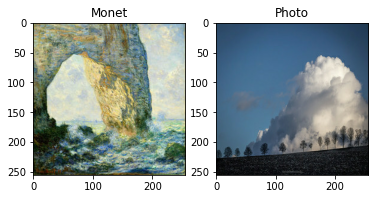

In [20]:
monet = next(iter(monet_df))
photo = next(iter(photo_df))

plt.subplot(121)
plt.title('Monet')
plt.imshow(monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo')
plt.imshow(photo[0] * 0.5 + 0.5)

# Model Architecture

A GAN (General Adversarial Network) model will need a generator and a discriminator. We'll first construct our generator. A generator uses a downsample and an upsample method. The downsample method reduces the image's width and height using filters. Since our images are of size 256x256, we'll be using filters with a stride of 2 to reduce our image faster thus reducing the time it takes to build and train our model. Our downsample method will also include a boolean argument to signify whether wer will use instance normalization. Whereas the upsample method increases the dimensions of the image. Our upsample method will include a boolean argument called dropout that will allow us to include Dropout in some layers when building our model.

In [21]:
# Downsample and Upsample

def downsample(filters, kernel_size, instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer, 
                              use_bias=False))
    if instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    layer.add(layers.LeakyReLU())

    return layer

def upsample(filters, kernel_size, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                                       kernel_initializer=initializer, use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

Our generator will include 7 layers of our downsample method and 6 layers of our upsample method. The first downsample layer will have 64 filters, a kernel size of 4, and it won't have instance normalization. The rest of downsample layers use instance normalization, and the number of filters for each downsample will double from the layer previous, maxing out at 512. The first two upsample layers will have 512 filters and include Dropout. The rest of the upsamples do not use Dropout and the number of filters halve in size starting from the third layer with 512 filters. We will use skip connections to concatenate our downsample layer to an upsample layer symmetrically. Our generator will also include a layer with 'tanh' activation.

In [22]:
# Generator

out_channels = 3

def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(out_channels, 4, strides=2, padding='same', kernel_initializer=initializer,
                                  activation='tanh')
    x = inputs
    skip_con = []
    for down in down_stack:
        x = down(x)
        skip_con.append(x)
    skip_con = reversed(skip_con[:-1])
    for up, skip in zip(up_stack, skip_con):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminator takes an image as an input and classifies it as a real or fake image. It will output an image with either higher pixel values (real image) or lower pixel values (fake image) depending on its classification of the input.

In [23]:
# Discriminator

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input = layers.Input(shape=[256, 256, 3], name='input_image')
    x = input
    down1 = downsample(64, 4, instancenorm=False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, kernel_size=4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, kernel_size=4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=input, outputs=last)

We'll use our Generator and Discriminator methods to create generators for the photos and Monet paintings.

In [24]:
with strategy.scope():
    monet_gen = Generator()
    photo_gen = Generator()
    monet_disc = Discriminator()
    photo_disc = Discriminator()

We need to set up a GAN class for creating our GAN model.

In [25]:
# GAN Class

class GAN(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10):
        super(GAN, self).__init__()
        self.m_gen, self.p_gen = monet_gen, photo_gen
        self.m_disc, self.p_disc = monet_disc, photo_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(self, m_gen_op, p_gen_op, m_disc_op, p_disc_op, gen_loss, disc_loss, cycle_loss, id_loss):
        super(GAN, self).compile()
        self.m_gen_op, self.p_gen_op = m_gen_op, p_gen_op
        self.m_disc_op, self.p_disc_op = m_disc_op, p_disc_op
        self.gen_loss, self.disc_loss = gen_loss, disc_loss
        self.cycle_loss, self.id_loss = cycle_loss, id_loss
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss(disc_fake_monet)
            photo_gen_loss = self.gen_loss(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.id_loss(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.id_loss(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_gen_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_op.apply_gradients(zip(monet_gen_gradients, self.m_gen.trainable_variables))
        self.p_gen_op.apply_gradients(zip(photo_gen_gradients, self.p_gen.trainable_variables))
        self.m_disc_op.apply_gradients(zip(monet_disc_gradients, self.m_disc.trainable_variables))
        self.p_disc_op.apply_gradients(zip(photo_disc_gradients, self.p_disc.trainable_variables))
        
        return {"monet_gen_loss": total_monet_gen_loss, "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss, "photo_disc_loss": photo_disc_loss}

Having written our GAN class, we will need to create loss functions for the generator and discriminator, as well as cycle consistency and identity loss. The generator loss function compares the generated image to a matrix of 1s (i.e. real image). The discriminator loss function calculates the average of real and generated loss. Our consistency loss function calculates the average difference between the original photo and our generated photo. The identity loss compares the input with the output of the generator. The generator and discriminator loss functions will use Binary Cross-Entropy.

In [26]:
# Generator Loss
with strategy.scope():
    def generator_loss(gen):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(gen), gen)

# Discriminator Loss
with strategy.scope():
    def discriminator_loss(real, gen):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                       reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                      reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(gen), gen)
        total_disc_loss = real_loss + gen_loss
        return total_disc_loss * 0.5
    
# Cycle Consistency Loss
with strategy.scope():
    def cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
# Identity Loss
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

We are finally ready to build our GAN model. We will use Adam optimization.

In [27]:
# Set up optimizers
with strategy.scope():
    monet_gen_op = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_op = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_disc_op = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_disc_op = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Set up model
with strategy.scope():
    GAN_model = GAN(monet_gen, photo_gen, monet_disc, photo_disc)

    GAN_model.compile(m_gen_op = monet_gen_op, p_gen_op = photo_gen_op, m_disc_op = monet_disc_op, 
                      p_disc_op = photo_disc_op, gen_loss = generator_loss, disc_loss = discriminator_loss, 
                      cycle_loss = cycle_loss, id_loss = identity_loss)

Finally we can train our model. As each epoch takes a while, unfortunately we'll only do a total of 10 iterations.

In [29]:
GAN_model.fit(tf.data.Dataset.zip((monet_df, photo_df)), epochs = 10)

Epoch 1/10
300/300 [==============================] - 1607s 5s/step - monet_gen_loss: 4.3276 - photo_gen_loss: 4.5023 - monet_disc_loss: 0.6593 - photo_disc_loss: 0.6216
Epoch 2/10
300/300 [==============================] - 1605s 5s/step - monet_gen_loss: 3.5206 - photo_gen_loss: 3.6619 - monet_disc_loss: 0.6715 - photo_disc_loss: 0.6396
Epoch 3/10
300/300 [==============================] - 1607s 5s/step - monet_gen_loss: 3.4807 - photo_gen_loss: 3.6014 - monet_disc_loss: 0.6581 - photo_disc_loss: 0.6221
Epoch 4/10
300/300 [==============================] - 1598s 5s/step - monet_gen_loss: 3.3470 - photo_gen_loss: 3.4797 - monet_disc_loss: 0.6503 - photo_disc_loss: 0.6187
Epoch 5/10
300/300 [==============================] - 1604s 5s/step - monet_gen_loss: 3.2382 - photo_gen_loss: 3.3541 - monet_disc_loss: 0.6385 - photo_disc_loss: 0.6112
Epoch 6/10
300/300 [==============================] - 1602s 5s/step - monet_gen_loss: 3.1654 - photo_gen_loss: 3.2438 - monet_disc_loss: 0.6286 - phot

# Results

Let's take a look at how our model does for generating images for the first 10 photos.

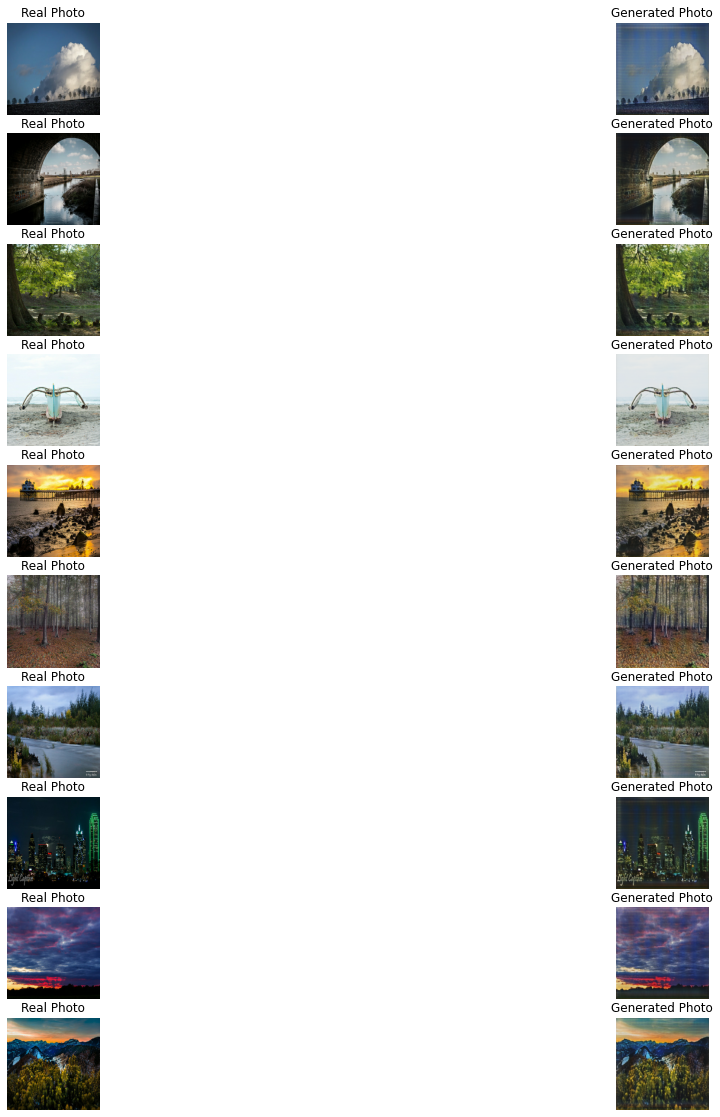

In [34]:
# Results

_, ax = plt.subplots(10, 2, figsize=(20, 20))
for i, image in enumerate(photo_df.take(10)):
    pred = monet_gen(image, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    image = (image[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(image)
    ax[i, 1].imshow(pred)
    ax[i, 0].set_title("Real Photo")
    ax[i, 1].set_title("Generated Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

As we can see by the plots, the images look very similar.

Submission:

In [35]:
import PIL
! mkdir ../images

i = 1
for image in photo_df:
    pred = monet_gen(image, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(pred)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [36]:
import shutil
shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusion

Our General Adversarial Network (GAN) model did well for generating images that appear real. Looking at the Loss metrics in the iterations, it looks like most, if not all, converged, which shows that 10 iterations was enough.